
>>> Loading Phys-only from ./out_pendulum_physonly/


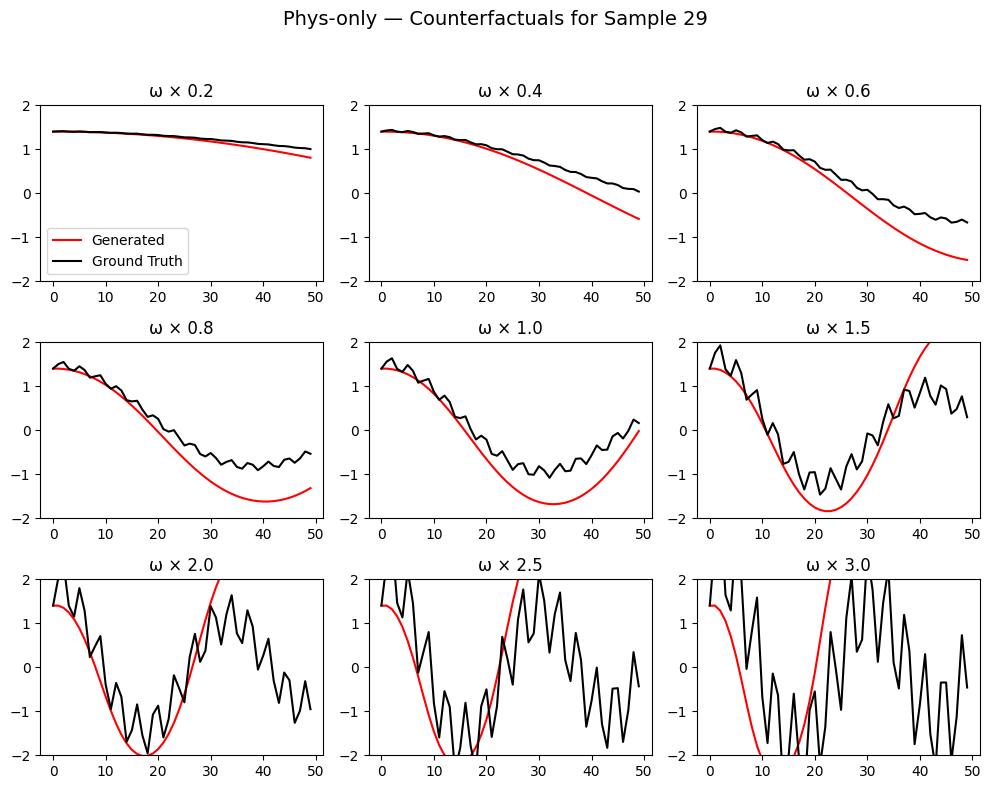


>>> Loading Phys+NN from ./out_pendulum_physnn/


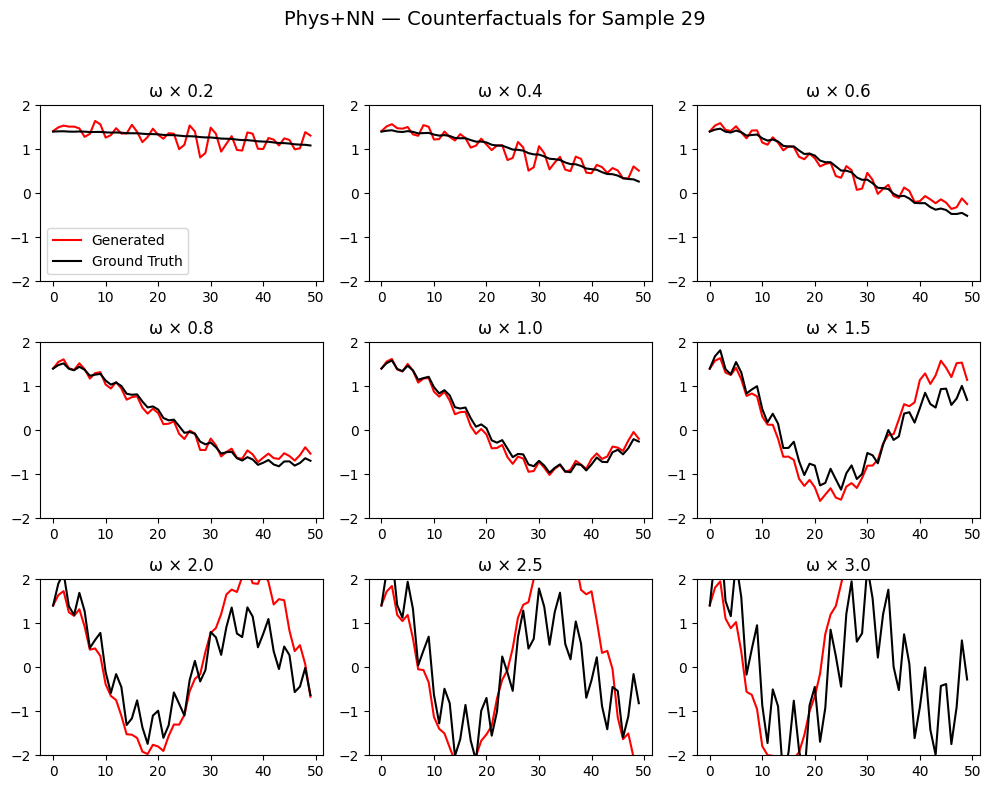

In [12]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae.pendulum.model import VAE

# === SETTINGS ===
datadir = './data/pendulum'
dataname = 'test'
modeldirs = {
    "Phys-only": './out_pendulum_physonly/',
    "Phys+NN": './out_pendulum_physnn/',
}
params_test = np.loadtxt(f'{datadir}/true_params_{dataname}.txt')
data_test = np.loadtxt(f'{datadir}/data_{dataname}.txt')

# === Prepare ===
device = torch.device("cpu")
import sys; sys.path.append('./data/pendulum/')
from generate import generate_traj
coeffs = [0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0]
idx = 29  # Which sample to show
n = 30

# === RUN FOR EACH MODEL ===
for label, modeldir in modeldirs.items():
    print(f"\n>>> Loading {label} from {modeldir}")

    with open(f'{modeldir}/args.json', 'r') as f:
        args_tr_dict = json.load(f)

    model = VAE(args_tr_dict).to(device)
    model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
    model.eval()

    dim_t = args_tr_dict['dim_t']
    dt = args_tr_dict['dt']
    data_tensor = torch.Tensor(data_test).to(device)
    init_y = data_tensor[:, 0].clone().view(-1, 1)

    with torch.no_grad():
        z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
        z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat, hard_z=False)

    assert z_phy.shape[1] == 1, f"{label}: Expected 1-dim physics latent"

    # Counterfactual z_phy
    cf_z_phy = [z_phy * c for c in coeffs]

    # Decode
    with torch.no_grad():
        cf_x = []
        for cfz in cf_z_phy:
            x_hat, _ = model.decode(cfz, z_aux1, z_aux2, init_y)
            cf_x.append(x_hat.cpu().numpy())

    # Ground truth
    dim_t = data_tensor.shape[1]
    cf_x_true = [np.empty((n, dim_t)) for _ in coeffs]
    for i in range(n):
        init_cond = [params_test[i, 0], 0.0]
        gamma = params_test[i, 2]
        A = params_test[i, 3]
        f = params_test[i, 4]
        for j in range(len(coeffs)):
            omega = cf_z_phy[j][i].item()
            t, tmp = generate_traj(init_cond, omega, gamma, A, f, dt, dim_t)
            cf_x_true[j][i] = tmp[:, 0]

    # Plot for one idx
    plt.figure(figsize=(10, 8))
    plt.suptitle(f"{label} — Counterfactuals for Sample {idx}", fontsize=14)
    for i in range(len(coeffs)):
        plt.subplot(3, 3, i + 1)
        plt.plot(cf_x[i][idx], 'r', label='Generated')
        plt.plot(cf_x_true[i][idx], 'k', label='Ground Truth')
        plt.ylim([-2.0, 2.0])
        plt.title(f"ω × {coeffs[i]}")
        if i == 0:
            plt.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



>>> Loading NN-only (0) from ./out_pendulum_nnonly0/
[NN-only (0)] No physics latent (z_phy) present. Skipping counterfactuals.


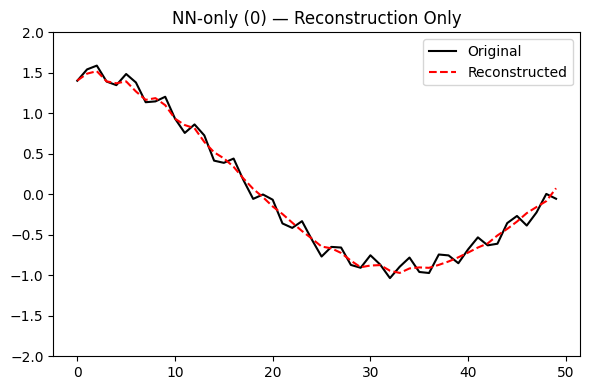


>>> Loading NN-only (1) from ./out_pendulum_nnonly1/
[NN-only (1)] No physics latent (z_phy) present. Skipping counterfactuals.


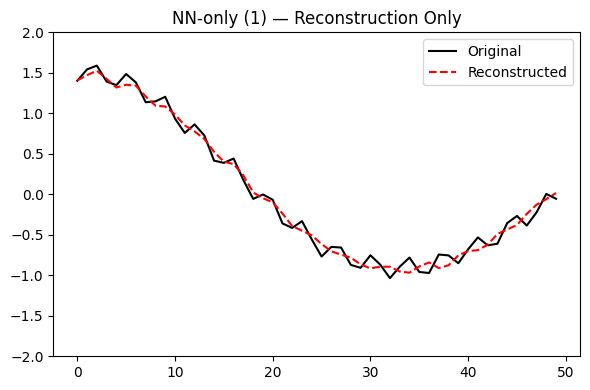

In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
from physvae.pendulum.model import VAE

# === SETTINGS ===
datadir = './data/pendulum'
dataname = 'test'
modeldirs = {
    "NN-only (0)": './out_pendulum_nnonly0/',
    "NN-only (1)": './out_pendulum_nnonly1/',
}

# === LOAD DATA ===
data_test = np.loadtxt(f'{datadir}/data_{dataname}.txt')
device = torch.device("cpu")

# === RUN FOR EACH MODEL ===
for label, modeldir in modeldirs.items():
    print(f"\n>>> Loading {label} from {modeldir}")
    
    with open(f'{modeldir}/args.json', 'r') as f:
        args_tr_dict = json.load(f)

    model = VAE(args_tr_dict).to(device)
    model.load_state_dict(torch.load(f'{modeldir}/model.pt', map_location=device))
    model.eval()

    dim_t = args_tr_dict['dim_t']
    data_tensor = torch.Tensor(data_test).to(device)
    init_y = data_tensor[:, 0].clone().view(-1, 1)

    with torch.no_grad():
        z_phy_stat, z_aux1_stat, z_aux2_stat, _ = model.encode(data_tensor)
        z_phy, z_aux1, z_aux2 = model.draw(z_phy_stat, z_aux1_stat, z_aux2_stat, hard_z=False)

    # Check z_phy shape
    if z_phy.shape[1] == 0:
        print(f"[{label}] No physics latent (z_phy) present. Skipping counterfactuals.")
        # Just do reconstruction and plot
        with torch.no_grad():
            x_recon, _ = model.decode(z_phy, z_aux1, z_aux2, init_y)
            x_recon = x_recon.cpu().numpy()

        # Plot for one example
        idx = 29
        plt.figure(figsize=(6, 4))
        plt.title(f"{label} — Reconstruction Only")
        plt.plot(data_test[idx], label='Original', color='black')
        plt.plot(x_recon[idx], '--', label='Reconstructed', color='red')
        plt.ylim([-2.0, 2.0])
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"[{label}] Has physics latent. You can run counterfactual simulation.")
